# Implementation
To begin, import the following libraries we are going to use in today’s lab.

In [1]:
import math
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras
from keras import layers

import numpy as np

Then, we need to import a dataset. As an example, we are going to use the Oxford Flower Dataset, a dataset which is built-in in Tensorflow, containing a large number of RGB images representing flowers.

To work with them, we first need to download the data from the tensorflow_datasets library. After that, we need to pre-process them to be 64x64x3 
 and, finally, we need to **normalize them to be in the interval [0,1]** 
, as it is common when working with neural networks. This can be done by the following function:

In [2]:
def preprocess_image(data):
    # center crop image
    height = tf.shape(data["image"])[0]
    width = tf.shape(data["image"])[1]
    crop_size = tf.minimum(height, width)
    image = tf.image.crop_to_bounding_box(
        data["image"],
        (height - crop_size) // 2,
        (width - crop_size) // 2,
        crop_size,
        crop_size,
    )

    # resize and clip
    # for image downsampling it is important to turn on antialiasing
    image = tf.image.resize(image, size=[image_size, image_size], antialias=True)
    return tf.clip_by_value(image / 255.0, 0.0, 1.0) # normalize in range [0,1]

Then, we can load the dataset from the tfds library. By calling the .map() method, we can also authomatically preprocess each image into the dataset with the function we just defined.

The dataset can be load with the function tfds.load(), that takes as input the name of the dataset and a string representing which part of the dataset to download, and returns a list whose first element is the TensorflowDataset object we are interested in. For computational reason, we also want to convert it into a numpy array.

We also want to setup some global parameters we will require in the following.

In [3]:
def load_and_preprocess_dataset(dataset_name, split="train"):
    #shuffle, split in train and test, normalize, repeat 5 times, finally convert in numpy array
    return np.array(list(tfds.load(dataset_name, shuffle_files=True, split=[split])[0].map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).repeat(5)))

# We consider the Oxford Flowers dataset. A dataset of 64 x 64 x 3 images.
dataset_name = "oxford_flowers102"
image_size = 64

# We also require some specifications to train the model
num_epochs = 50
batch_size = 60

train_dataset = load_and_preprocess_dataset(dataset_name, split="train")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1020 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/2.1.1.incompletePQYXQV/oxford_flowers102-train.tfrecord*…

Shuffling /root/tensorflow_datasets/oxford_flowers102/2.1.1.incompletePQYXQV/oxford_flowers102-test.tfrecord*.…

Generating validation examples...:   0%|          | 0/1020 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/2.1.1.incompletePQYXQV/oxford_flowers102-validation.tfre…

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.


Overfitting is not a thing in diffusion (it exist but it's a totally different concept than classical ML)

In [4]:
print(train_dataset.shape)

(5100, 64, 64, 3)


# Model
As a network, we are going to use a UNet, which is known to be particularly effective. To **feed the network with TWO INPUTS** ($x_t$=noisy image at timestep t and $α_t$). we are going to use a common technique, which consists in two parts:

- We define a (positional) **Embedding function**, that embeds 
 into a larger, more informative space (embed an image from a scalar number).
- We **upsample the embedded $\alpha_t$**
 to have the same shape of $x_t$
 and we concatenate them. The result will be then processed by the network to produce the output.


The embedding function we considered is the sinuisodal embedding, introduced in the DDIM paper.



In [5]:
# Define the embedding for the noise variance that we want to feed to the network.
# Here we use sinuisodal embedding as in the original paper of DDIM.
def sinusoidal_embedding(x):
    embedding_min_frequency = 1.0
    frequencies = tf.exp(
        tf.linspace(
            tf.math.log(embedding_min_frequency),
            tf.math.log(embedding_max_frequency),
            embedding_dims // 2,
        )
    )
    angular_speeds = 2.0 * math.pi * frequencies
    embeddings = tf.concat(
        [tf.sin(angular_speeds * x), tf.cos(angular_speeds * x)], axis=3
    )
    return embeddings

# Set max and frequency and embedding dimension
embedding_dims = 32
embedding_max_frequency = 1000.0

In [6]:
# Check the behavior
variance = tf.Variable([[[[0.2]]]]) # We want the shape of t to be like (N, 1, 1, 1)
                             # (it has to be at least 4-dimensional).

e_variance = sinusoidal_embedding(variance)

print(f"Variance: {variance.numpy()[0, 0, 0, 0]:.1f}. Embedding of time: \n{e_variance[0, 0, 0, :]}")

Variance: 0.2. Embedding of time: 
[ 9.5105654e-01  9.1274637e-01 -1.4936695e-02 -9.5813704e-01
  9.9719906e-01  3.4969111e-07  8.7565929e-01  1.4881670e-01
 -2.3561993e-01 -6.8063998e-01  5.4042598e-06 -9.4682550e-01
  9.9702632e-01 -6.9101417e-01  9.3320602e-01  1.4559533e-04
  3.0901697e-01 -4.0852669e-01 -9.9988842e-01  2.8630993e-01
 -7.4792907e-02  1.0000000e+00  4.8292947e-01  9.8886478e-01
  9.7184527e-01 -7.3261809e-01  1.0000000e+00 -3.2174751e-01
  7.7061631e-02 -7.2284126e-01  3.5934180e-01  1.0000000e+00]


## U-NET

In [7]:
# Define the UNet, which is the network portion that predict the noise given
# x_t and alpha_t.
def ResidualBlock(width):
    def apply(x):
        input_width = x.shape[3]
        if input_width == width:
            residual = x
        else:
            residual = layers.Conv2D(width, kernel_size=1)(x)
        x = layers.BatchNormalization(center=False, scale=False)(x)
        x = layers.Conv2D(
            width, kernel_size=3, padding="same", activation=keras.activations.swish)(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same")(x)
        x = layers.Add()([x, residual])
        return x

    return apply


def DownBlock(width, block_depth):
    def apply(x):
        x, skips = x
        for _ in range(block_depth):
            x = ResidualBlock(width)(x)
            skips.append(x)
        x = layers.AveragePooling2D(pool_size=2)(x)
        return x

    return apply


def UpBlock(width, block_depth):
    def apply(x):
        x, skips = x
        x = layers.UpSampling2D(size=2, interpolation="bilinear")(x)
        for _ in range(block_depth):
            x = layers.Concatenate()([x, skips.pop()])
            x = ResidualBlock(width)(x)
        return x

    return apply


def get_network(image_size, widths, block_depth):
    # Since alpha_t and the variance of the noise are related (the noise has
    # variance sqrt(1 - alpha_t), we feed the network with the image and the
    # noise variance.

    # Then, we embed the noise variance to expand the informations and we 
    # upsample it to have the same shape of the input, with the intent of 
    # concatenating them. This is a naive (but effective) way of passing more 
    # than one information through an image-to-image network.
    noisy_images = keras.Input(shape=(image_size, image_size, 3))
    noise_variances = keras.Input(shape=(1, 1, 1))

    e = layers.Lambda(sinusoidal_embedding)(noise_variances) #apply embedding
    e = layers.UpSampling2D(size=image_size, interpolation="nearest")(e) #upsample to (64,64,1)

    x = layers.Conv2D(widths[0], kernel_size=1)(noisy_images)
    x = layers.Concatenate()([x, e]) # concatenate noise with the embedded image (alpha_t)

    # Unet structure
    skips = []
    for width in widths[:-1]:
        x = DownBlock(width, block_depth)([x, skips])

    for _ in range(block_depth):
        x = ResidualBlock(widths[-1])(x)

    for width in reversed(widths[:-1]):
        x = UpBlock(width, block_depth)([x, skips])

    x = layers.Conv2D(3, kernel_size=1, kernel_initializer="zeros")(x)

    return keras.Model([noisy_images, noise_variances], x, name="residual_unet")

## The diffusion schedule
Another key component we introduced is the diffusion schedule, i.e. the function that associate 
 to a given 
. This can be done in various way, but it has been proved that the quality of the resulting model improves if the schedule is such that it smoothly decreases from 1 to 0, with plateu around the two extremal points. We did that by considering the cosine schedule:

Each schedule can have different outcomes, and need different numbers of steps to produce good results

In [8]:
def diffusion_schedule(diffusion_times):
    # This implements the generator for alpha_t given t. In particular, 
    # given a batch of times (shape (N, 1, 1, 1)), we return the batch of
    # corresponding alpha_t, using a "cosine schedule" (the implementation
    # of the cosine schedule follows the GitHub of gDDIM).

    # Since we don't want alpha_t to be exactly 0 or 1 (for numerical 
    # instabilities), we set a maximum value of alpha_t and a minimum.
    max_signal_rate = 0.95
    min_signal_rate = 0.02

    start_angle = tf.acos(max_signal_rate)
    end_angle = tf.acos(min_signal_rate)

    diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)

    # angles -> signal and noise rates
    signal_rates = tf.cos(diffusion_angles) # This is sqrt(alpha_t)
    noise_rates = tf.sin(diffusion_angles)  # This is sqrt(1 - alpha_t)
    # note that their squared sum is always: sin^2(x) + cos^2(x) = 1

    return noise_rates, signal_rates

The following code will visualize the way the schedule decreases to 0:



Shape of t_vec: (20,). Shape of alpha_t_vec: (20,).


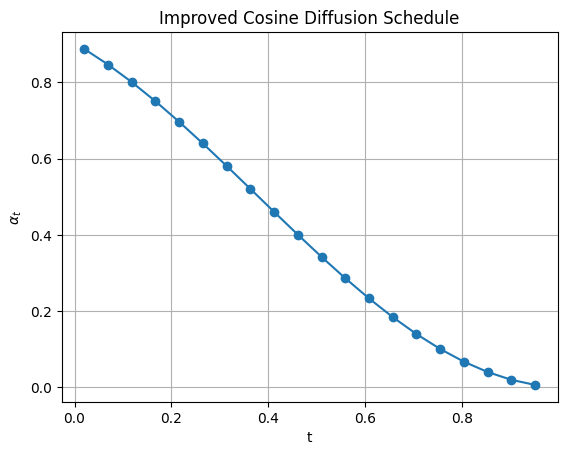

In [9]:
t_vec = tf.linspace(0.02, 0.95, 20)
_, sqrt_alpha_t_vec = diffusion_schedule(t_vec)
alpha_t_vec = tf.math.square(sqrt_alpha_t_vec)

print(f"Shape of t_vec: {t_vec.shape}. Shape of alpha_t_vec: {alpha_t_vec.shape}.")

# Plot the schedule to check the behavior
plt.plot(t_vec, alpha_t_vec, 'o-')
plt.grid()
plt.xlabel('t')
plt.ylabel(r'$\alpha_t$')
plt.title("Improved Cosine Diffusion Schedule")
plt.show()

the smaller $\alpha_t$, the closer $x_t$ is to pure noise.<br>
This schedule function is horizontal at start and end, and it's steaper in the middle.
# Diffusion model
putting everything togeter, we finally get the DiffusionModel class

In [10]:
class DiffusionModel(keras.Model):
    def __init__(self, image_size, widths, block_depth):
        super().__init__()

        self.normalizer = layers.Normalization()
        self.network = get_network(image_size, widths, block_depth)
        self.ema_network = keras.models.clone_model(self.network)

    def compile(self, **kwargs):
        super().compile(**kwargs)

        self.noise_loss_tracker = keras.metrics.Mean(name="n_loss")
        self.image_loss_tracker = keras.metrics.Mean(name="i_loss")

    @property
    def metrics(self):
        return [self.noise_loss_tracker, self.image_loss_tracker]

    def denormalize(self, images):
        # convert the pixel values back to 0-1 range
        images = self.normalizer.mean + images * self.normalizer.variance**0.5
        return tf.clip_by_value(images, 0.0, 1.0)

    def denoise(self, noisy_images, noise_rates, signal_rates, training): #applies network (unet) to predict noise
        # the exponential moving average weights are used at evaluation
        if training:
            network = self.network
        else:
            network = self.ema_network

        # predict noise component and calculate the image component using it
        pred_noises = network([noisy_images, noise_rates**2], training=training)
        pred_images = (noisy_images - noise_rates * pred_noises) / signal_rates #applies denoising to x_t given the predicted one

        return pred_noises, pred_images

    #recreates clean image! diffusion_step=how many backsteps you whant to take.
    #research on diffusion models is based on reducing steps while retaining quality
    def reverse_diffusion(self, initial_noise, diffusion_steps):
        # reverse diffusion = sampling
        num_images = initial_noise.shape[0]
        step_size = 1.0 / diffusion_steps

        # important line:
        # at the first sampling step, the "noisy image" is pure noise
        # but its signal rate is assumed to be nonzero (min_signal_rate)!!!
        next_noisy_images = initial_noise
        for step in range(diffusion_steps): #repeat foreach step
            noisy_images = next_noisy_images

            # separate the current noisy image to its components
            diffusion_times = tf.ones((num_images, 1, 1, 1)) - step * step_size
            noise_rates, signal_rates = diffusion_schedule(diffusion_times) #alpha t
            pred_noises, pred_images = self.denoise( #x_0 tilde
                noisy_images, noise_rates, signal_rates, training=False
            )
            # network used in eval mode

            # remix the predicted components using the next signal and noise rates
            next_diffusion_times = diffusion_times - step_size
            next_noise_rates, next_signal_rates = diffusion_schedule(
                next_diffusion_times
            )
            next_noisy_images = ( #x_t-1 
                next_signal_rates * pred_images + next_noise_rates * pred_noises
            )
            # this new noisy image will be used in the next step

        return pred_images

    def generate(self, num_images, diffusion_steps):
        # noise -> images -> denormalized images
        initial_noise = tf.random.normal(shape=(num_images, image_size, image_size, 3))
        generated_images = self.reverse_diffusion(initial_noise, diffusion_steps)
        generated_images = self.denormalize(generated_images)
        return generated_images

    def train_step(self, images):
        # normalize images to have standard deviation of 1, like the noises
        images = self.normalizer(images, training=True)
        noises = tf.random.normal(shape=(batch_size, image_size, image_size, 3)) #sample noise (from normal dist)

        # sample uniform ([0,1] range) random diffusion times
        diffusion_times = tf.random.uniform(
            shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0
        )
        noise_rates, signal_rates = diffusion_schedule(diffusion_times) #given by our cosine schedule
        # mix the images with noises accordingly
        noisy_images = signal_rates * images + noise_rates * noises #generate x_t (noisy image at timestep t)

        with tf.GradientTape() as tape:
            # train the network to separate noisy images to their components
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, signal_rates, training=True
            )

            noise_loss = self.loss(noises, pred_noises)  # used for training
            image_loss = self.loss(images, pred_images)  # only used as metric

        gradients = tape.gradient(noise_loss, self.network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.network.trainable_weights))

        self.noise_loss_tracker.update_state(noise_loss)
        self.image_loss_tracker.update_state(image_loss)

        # track the exponential moving averages of weights
        for weight, ema_weight in zip(self.network.weights, self.ema_network.weights):
            ema_weight.assign(0.999 * ema_weight + (1 - 0.999) * weight)

        return {m.name: m.result() for m in self.metrics[:-1]}

## Training

In [11]:
# Define the parametters for the model
widths = [32, 64, 96, 128]
block_depth = 2

# create and compile the model
model = DiffusionModel(image_size, widths, block_depth)

# Optimizer specifications
learning_rate = 1e-3
weight_decay = 1e-4

model.compile(
    optimizer=keras.optimizers.experimental.AdamW( #adamW optimizer, current trend in optimizers to handle weight decay
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    loss=keras.losses.mean_absolute_error, #mean_absolute_error is experimentally better in diffusion (dunno why)
)
# pixelwise mean absolute error is used as loss

# calculate mean and variance of training dataset for normalization
model.normalizer.adapt(train_dataset)

# run training and plot generated images periodically
model.fit(
    train_dataset,
    epochs=num_epochs,
    batch_size=batch_size,
)

Epoch 1/50
85/85 [==============================] - 43s 163ms/step - n_loss: 0.3403
Epoch 2/50
85/85 [==============================] - 14s 165ms/step - n_loss: 0.2057
Epoch 3/50
85/85 [==============================] - 14s 165ms/step - n_loss: 0.1941
Epoch 4/50
85/85 [==============================] - 14s 166ms/step - n_loss: 0.1837
Epoch 5/50
85/85 [==============================] - 14s 168ms/step - n_loss: 0.1804
Epoch 6/50
85/85 [==============================] - 14s 170ms/step - n_loss: 0.1749
Epoch 7/50
85/85 [==============================] - 15s 173ms/step - n_loss: 0.1745
Epoch 8/50
85/85 [==============================] - 15s 177ms/step - n_loss: 0.1719
Epoch 9/50
85/85 [==============================] - 15s 177ms/step - n_loss: 0.1701
Epoch 10/50
85/85 [==============================] - 15s 173ms/step - n_loss: 0.1666
Epoch 11/50
85/85 [==============================] - 15s 175ms/step - n_loss: 0.1651
Epoch 12/50
85/85 [==============================] - 15s 173ms/step - n_lo

In [14]:
model.network.save_weights("diffusion_flowers.h5")

# Plot results

In [17]:
# Generate num_images samples.
num_images=18
diffusion_steps=20
x_T = tf.random.normal(shape=(num_images, image_size, image_size, 3))
x_0 = model.reverse_diffusion(x_T, diffusion_steps)
x_0 = model.denormalize(x_0)

In [18]:
def plot_images(model, num_rows=3, num_cols=6, plot_diffusion_steps=20):
    # plot random generated images for visual evaluation of generation quality
    generated_images = model.generate(
        num_images=num_rows * num_cols,
        diffusion_steps=plot_diffusion_steps,
    )

    plt.figure(figsize=(num_cols * 2.0, num_rows * 2.0))
    for row in range(num_rows):
        for col in range(num_cols):
            index = row * num_cols + col
            plt.subplot(num_rows, num_cols, index + 1)
            plt.imshow(generated_images[index])
            plt.axis("off")
    plt.tight_layout()
    plt.show()
    plt.close()

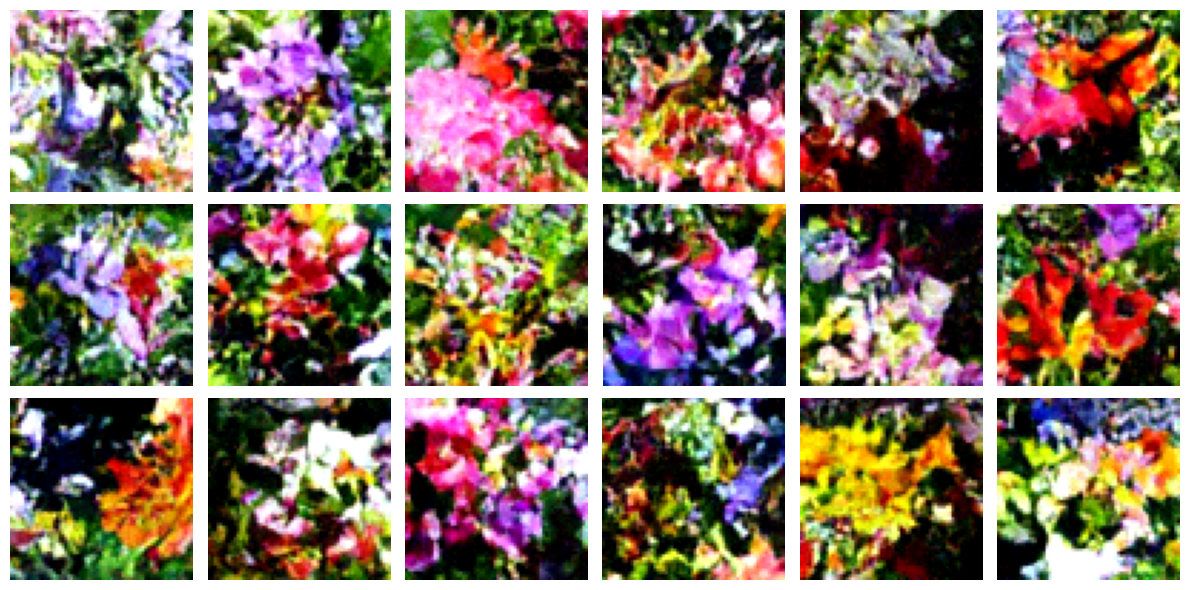

In [19]:
plot_images(model)